In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

GENERATION_DAYS=5
SAMPLE_DATE='2021-07-13'
SAMPLE_FILE='last-6-months-nsw-20210714.csv'

pd.set_option('display.max_rows', None)

In [4]:
def load_data(fn):
    df=pd.read_csv(fn).rename({
        'Date': 'date',
        'Overseas-acquired': 'overseas',
        'Known local source': 'local',
        'Unknown local source (community spread)': 'unknown', 
        'Interstate travel': 'interstate',
        'Under investigation': 'under-investigation'
    }, axis=1)
    df['total']=df['local']+df['unknown']+df['under-investigation']
    df['cumulative'] = df['total'].cumsum()    
    return edit_dates(df)

def rewrite_date(d):
    p = d.split('/')
    return '-'.join(['20'+p[2], p[1], p[0]])

def select_outbreak(df, condition):
    subset_df = df.loc[condition].copy().reset_index(drop=True)
    start_total, start_cumulative = subset_df[['total', 'cumulative']].head(1).values[0]
    subset_df['cumulative'] = subset_df['cumulative'] - start_cumulative + start_total
    
    endog=np.log(subset_df['cumulative'])
    exog=sm.add_constant(subset_df.index)
    model = RollingOLS(endog=endog, exog=exog, window=GENERATION_DAYS, min_nobs=GENERATION_DAYS)
    subset_df['ols-growth-rate']=((np.exp(model.fit().params['x1'])-1)*100)
    subset_df['ratio-growth-rate']=((subset_df['cumulative']/subset_df['cumulative'].shift(GENERATION_DAYS))**(1/GENERATION_DAYS)-1)*100    
    subset_df['Reff'] = ((subset_df['ols-growth-rate']+100)/100)**GENERATION_DAYS
    subset_df['doubling-period'] = np.log(2)/np.log(((subset_df['ols-growth-rate']+100)/100))
    l = len(subset_df)
    d = 7
    stats = subset_df.tail(5)
    _median = stats['ols-growth-rate'].median()
    _min = stats['ols-growth-rate'].min()
    _max = stats['ols-growth-rate'].max()
    _last = stats['cumulative'].max()
    for n in ['min', 'max', 'median']:
        subset_df[n] = subset_df['cumulative']
    subset_df = subset_df.reindex(range(0,l+d))  
    subset_df.loc[subset_df.index >= l, ['min']] = [_last * ((_min+100)/100) ** (r+1) for r in range(0, d)]
    subset_df.loc[subset_df.index >= l, ['max']] = [_last * ((_max+100)/100) ** (r+1) for r in range(0, d)]
    subset_df.loc[subset_df.index >= l, ['median']] = [_last * ((_median+100)/100) ** (r+1) for r in range(0, d)]
    subset_df.loc[subset_df.index >= l, ['median_total']] = subset_df[subset_df.index >= l]['median'] - subset_df.shift(1)[subset_df.index >= l]['median']
    return subset_df
    
def edit_dates(df):
    newyear=df['date'][df['date']=='01/01'].index.values[0]
    df.loc[df.index < newyear,['date']]=df['date'].loc[df.index < newyear]+'/20'
    df.loc[df.index >= newyear,['date']]=df['date'].loc[df.index >= newyear]+'/21'
    df['date']=df['date'].apply(rewrite_date)
    return df

def load_vic_data(fn):
    df=pd.read_csv(fn).rename({
        'Acquired in Australia, unknown source': 'unknown',
        'Contact with a confirmed case	': 'local',
        'Travel overseas': 'overseas'
    })

    df['count']=1
    df=df.pivot_table(index=['diagnosis_date'], columns=['acquired'], values=['count'], aggfunc=np.sum)
    
    tmp=df
    df=pd.DataFrame(data=df.values, columns=['unknown', 'local', 'overseas'])
    df[df.loc[:,['unknown']].isna()]=0
    df[df.loc[:,['local']].isna()]=0
    df[df.loc[:,['overseas']].isna()]=0
    df['under-investigation']=0
    
    df=pd.DataFrame(data=df.values, columns=['unknown', 'local', 'overseas', 'under-investigation'], dtype=int)
    df['date']=tmp.index

    df['total']=df['local']+df['unknown']+df['under-investigation']
    df['cumulative'] = df['total'].cumsum()    
    return df

In [5]:
nsw_df = load_data(SAMPLE_FILE)
vic_df = load_vic_data('all-vic-cases.csv')

In [6]:
avalon = select_outbreak(nsw_df, (nsw_df['date'] >= '2020-12-17') & (nsw_df['date'] <= '2021-01-16'))
bondi = select_outbreak(nsw_df, (nsw_df['date'] >= '2021-06-17'))
vic_outbreak = select_outbreak(vic_df, (vic_df['date'] >= '2020-05-27') & (vic_df['date'] < '2020-10-05'))

In [7]:
output=pd.DataFrame()

output['vic']=vic_outbreak['ols-growth-rate']
output['avalon']=avalon['ols-growth-rate']
output['bondi']=bondi['ols-growth-rate']

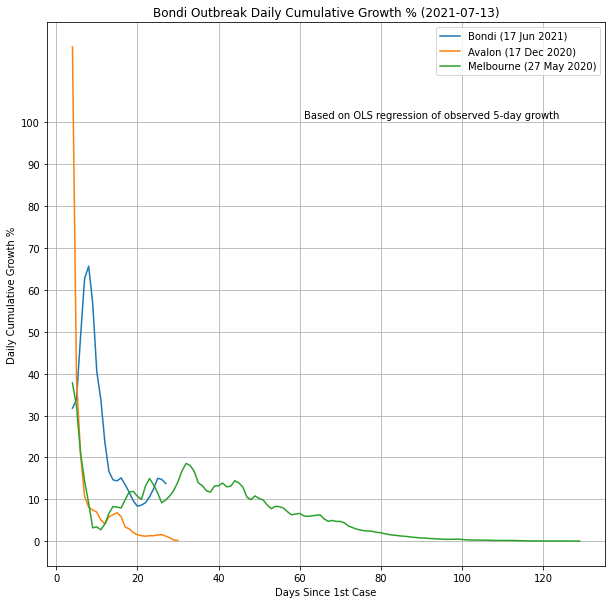

In [8]:
ax=output[['bondi', 'avalon', 'vic']].plot(
    title=f"Bondi Outbreak Daily Cumulative Growth % ({SAMPLE_DATE})", 
    figsize=(10,10)
)
ax.set_xlabel('Days Since 1st Case')
ax.set_yticks(range(0,110,10))
ax.set_ylabel('Daily Cumulative Growth %')
ax.text(61,101, "Based on OLS regression of observed 5-day growth")
ax.legend(['Bondi (17 Jun 2021)', 'Avalon (17 Dec 2020)', 'Melbourne (27 May 2020)'])
ax.grid()

,min,max,median,cumulative,vic,vic-offset
0,3.000000,3.000000,3.000000,3.0,7.0,39.0
1,4.000000,4.000000,4.000000,4.0,10.0,43.0
2,6.000000,6.000000,6.000000,6.0,16.0,48.0
3,7.000000,7.000000,7.000000,7.0,21.0,51.0
4,9.000000,9.000000,9.000000,9.0,24.0,53.0
5,14.000000,14.000000,14.000000,14.0,33.0,60.0
6,31.000000,31.000000,31.000000,31.0,33.0,71.0
7,43.000000,43.000000,43.000000,43.0,35.0,77.0
8,64.000000,64.000000,64.000000,64.0,36.0,82.0
9,92.000000,92.000000,92.000000,92.0,37.0,93.0


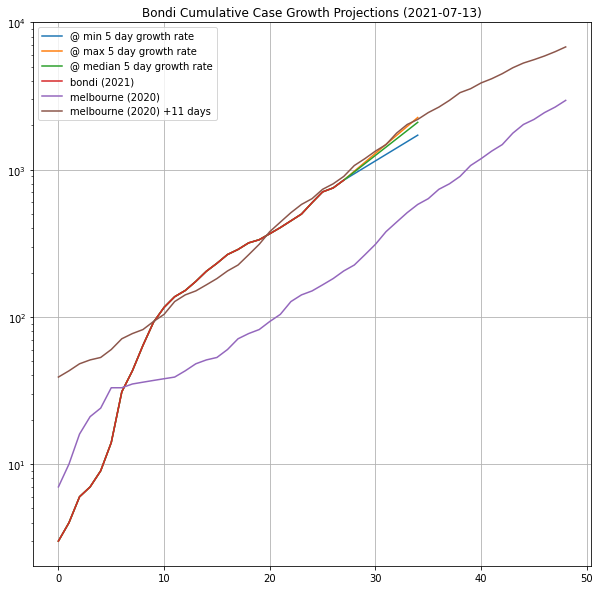

In [9]:
output=pd.DataFrame(columns=['min', 'max', 'median', 'cumulative', 'vic'])
output[['min', 'max', 'median', 'cumulative']] = bondi[['min', 'max', 'median', 'cumulative']]
output=output.reindex([r for r in range(0, len(bondi)+14)])
output['vic'] = vic_outbreak['cumulative']
x=11
output['vic-offset'] = vic_outbreak['cumulative'].shift(-x)
ax=output.plot(figsize=(10,10))
ax.set_yscale('log')
ax.grid()
ax.set_title(f'Bondi Cumulative Case Growth Projections ({SAMPLE_DATE})')
ax.legend([
    '@ min 5 day growth rate', 
    '@ max 5 day growth rate', 
    '@ median 5 day growth rate', 
    'bondi (2021)', 
    'melbourne (2020)',
    f'melbourne (2020) +{x} days'
])
_=_
output

In [10]:
bondi[['date', 'cumulative', 'ols-growth-rate', 'ratio-growth-rate', 'Reff', 'total', 'median_total', "min", "max", "median", 'doubling-period']]

,date,cumulative,ols-growth-rate,ratio-growth-rate,Reff,total,median_total,min,max,median,doubling-period
0,2021-06-17,3.0,NaN,NaN,NaN,3.0,NaN,3.000000,3.000000,3.000000,NaN
1,2021-06-18,4.0,NaN,NaN,NaN,1.0,NaN,4.000000,4.000000,4.000000,NaN
2,2021-06-19,6.0,NaN,NaN,NaN,2.0,NaN,6.000000,6.000000,6.000000,NaN
3,2021-06-20,7.0,NaN,NaN,NaN,1.0,NaN,7.000000,7.000000,7.000000,NaN
4,2021-06-21,9.0,31.743154,NaN,3.968627,2.0,NaN,9.000000,9.000000,9.000000,2.514281
5,2021-06-22,14.0,33.789717,36.082211,4.286607,5.0,NaN,14.000000,14.000000,14.000000,2.381138
6,2021-06-23,31.0,48.848714,50.612265,7.306770,17.0,NaN,31.000000,31.000000,31.000000,1.742625
7,2021-06-24,43.0,62.699419,48.273466,11.400660,12.0,NaN,43.000000,43.000000,43.000000,1.424077
8,2021-06-25,64.0,65.623339,55.674108,12.462572,21.0,NaN,64.000000,64.000000,64.000000,1.373804
9,2021-06-26,92.0,56.680081,59.187537,9.442107,28.0,NaN,92.000000,92.000000,92.000000,1.543634


In [11]:
vic_outbreak

,unknown,local,overseas,under-investigation,date,total,cumulative,ols-growth-rate,ratio-growth-rate,Reff,doubling-period,min,max,median,median_total
0,0.0,7.0,3.0,0.0,2020-05-27,7.0,7.0,NaN,NaN,NaN,NaN,7.000000,7.000000,7.000000,NaN
1,1.0,2.0,3.0,0.0,2020-05-28,3.0,10.0,NaN,NaN,NaN,NaN,10.000000,10.000000,10.000000,NaN
2,1.0,5.0,2.0,0.0,2020-05-29,6.0,16.0,NaN,NaN,NaN,NaN,16.000000,16.000000,16.000000,NaN
3,1.0,4.0,3.0,0.0,2020-05-30,5.0,21.0,NaN,NaN,NaN,NaN,21.000000,21.000000,21.000000,NaN
4,2.0,1.0,1.0,0.0,2020-05-31,3.0,24.0,37.798525,NaN,4.968472,2.161880,24.000000,24.000000,24.000000,NaN
5,5.0,4.0,0.0,0.0,2020-06-01,9.0,33.0,32.224494,36.358803,4.041658,2.481455,33.000000,33.000000,33.000000,NaN
6,0.0,0.0,7.0,0.0,2020-06-02,0.0,33.0,20.922817,26.970488,2.585481,3.648483,33.000000,33.000000,33.000000,NaN
7,1.0,1.0,6.0,0.0,2020-06-03,2.0,35.0,14.340482,16.947142,1.954340,5.172335,35.000000,35.000000,35.000000,NaN
8,1.0,0.0,2.0,0.0,2020-06-04,1.0,36.0,9.087167,11.382418,1.544786,7.969309,36.000000,36.000000,36.000000,NaN
9,1.0,0.0,0.0,0.0,2020-06-05,1.0,37.0,3.208725,9.043077,1.171068,21.946700,37.000000,37.000000,37.000000,NaN


In [12]:
def amnesic_growth(rate=1.5, days=100, window_size=14):
    window = np.zeros(shape=(window_size))
    population = 0.0
    cumulative = 0
    for d in range(0,days):
        old_population = window[d%window_size]
        if (population-window[d%window_size]) > 0:
            next_population = (population-window[d%window_size]) * (rate-1) + population
        elif d == 0:
            next_population = 1
        else:
            next_population = population
        total = int(next_population) - int(population) 
        cumulative += total
        prev_population = population
        population = next_population
        window[d%window_size] = next_population
        yield d, total, cumulative, population, prev_population, old_population


In [13]:
synthetic_df=pd.DataFrame(data=amnesic_growth(rate=1.08, days=1000, window_size=14), columns=['day', 'total', 'cumulative', 'population', 'prev_population', 'old_population'])
synthetic_outbreak=select_outbreak(synthetic_df, synthetic_df['cumulative']>0)

/usr/local/lib/python3.9/site-packages/statsmodels/regression/rolling.py:265: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood


In [14]:
synthetic_outbreak

,day,total,cumulative,population,prev_population,old_population,ols-growth-rate,ratio-growth-rate,Reff,doubling-period,min,max,median,median_total
0,0.0,1.0,1.0,1.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN
1,1.0,0.0,1.0,1.080000,1.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN
2,2.0,0.0,1.0,1.166400,1.080000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN
3,3.0,0.0,1.0,1.259712,1.166400,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN
4,4.0,0.0,1.0,1.360489,1.259712,0.000000,0.000000e+00,NaN,1.000000,inf,1.000000,1.000000,1.000000,NaN
5,5.0,0.0,1.0,1.469328,1.360489,0.000000,0.000000e+00,0.000000,1.000000,inf,1.000000,1.000000,1.000000,NaN
6,6.0,0.0,1.0,1.586874,1.469328,0.000000,0.000000e+00,0.000000,1.000000,inf,1.000000,1.000000,1.000000,NaN
7,7.0,0.0,1.0,1.713824,1.586874,0.000000,0.000000e+00,0.000000,1.000000,inf,1.000000,1.000000,1.000000,NaN
8,8.0,0.0,1.0,1.850930,1.713824,0.000000,0.000000e+00,0.000000,1.000000,inf,1.000000,1.000000,1.000000,NaN
9,9.0,0.0,1.0,1.999005,1.850930,0.000000,0.000000e+00,0.000000,1.000000,inf,1.000000,1.000000,1.000000,NaN


<AxesSubplot:>

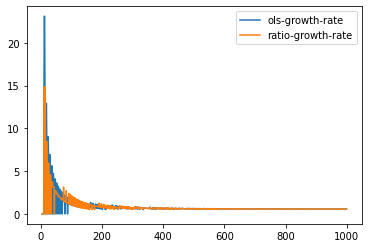

In [15]:
synthetic_outbreak[["ols-growth-rate", "ratio-growth-rate"]].plot()

In [ ]:
synthetic_outbreak.loc[:,["population"]].plot()